# Behold.ai - brain scanner classification

***

# Summary:
### I. Data Exploration
1) Images exploration <br>
2) Labels exploration <br>
### II. Data Preprocessing
1) Formatting the dataframe<br>
2) Data pipeline 1: Defining functions loading images and feeding images (model.fit used for 1st model) <br>
3) Data Pipeline 2: Feeding models with batches of images (model.fit_generator used for 2nd, 3rd model)
### III. Building and training neural networks
1) 1st Neural Network <br>
2) 2nd Neural Network <br>
3) 3rd Neural Network
### IV. Predictions on test data

### Conclusion


***

### Import necessary libraries

In [142]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import numpy as np

from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
from keras.utils import plot_model

***

# I) Data exploration

## I.1) Images exploration

float32
(128, 128)


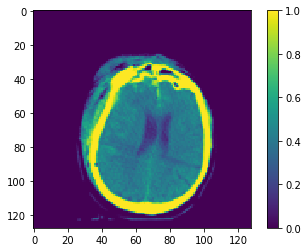

In [240]:
# load the first image of the  data set as pixel array
photo_0 = image.imread('train_images/train_images/train_0.png')

# summarize shape of the pixel array
print(photo_0.dtype)
print(photo_0.shape)

# display the array of pixels as an image
plt.imshow(photo_0)
plt.colorbar()
plt.show()


## I.2) Labels exploration

In [144]:
# Read training set labels from filename.csv
df = pd.read_csv('behold_coding_challenge_train.csv')

# Rename column for convenience
df = df.rename(columns={'epidural': 'epi'}) 
df = df.rename(columns={'intraparenchymal': 'int'}) 
df = df.rename(columns={'subarachnoid': 'sub'}) 

# Output 
print('Quick view of the data in the csv file')
df

Quick view of the data in the csv file


,Unnamed: 0,ID,epi,int,sub
0,0,train_0,1,0,1
1,1,train_1,1,0,0
2,2,train_2,1,0,1
3,3,train_3,1,0,1
4,4,train_4,1,0,0
...,...,...,...,...,...
8537,8588,train_8588,0,0,0
8538,8589,train_8589,0,0,0
8539,8590,train_8590,0,0,0
8540,8591,train_8591,0,0,0


Let's get some more insights from the dataset and check for missing data

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8542 entries, 0 to 8541
Data columns (total 5 columns):
Unnamed: 0    8542 non-null int64
ID            8542 non-null object
epi           8542 non-null int64
int           8542 non-null int64
sub           8542 non-null int64
dtypes: int64(4), object(1)
memory usage: 333.8+ KB


Fortunately, there is no missing data, after double check in the csv file, we can move on.

classes dataframe
     epi int sub classes
0      1   0   1     101
1      1   0   0     100
2      1   0   1     101
3      1   0   1     101
4      1   0   0     100
...   ..  ..  ..     ...
8537   0   0   0     000
8538   0   0   0     000
8539   0   0   0     000
8540   0   0   0     000
8541   0   0   0     000

[8542 rows x 4 columns]
Classes count
000    3463
010    1873
001    1654
011    1211
100     180
110      68
101      53
111      40
Name: classes, dtype: int64


Text(0.5, 1.0, 'Count Plot of classes in decreasing order')

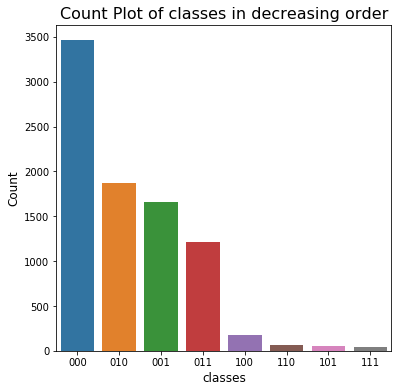

In [146]:
# Creating a string column in the dataframe giving the different classes of the brain damage:
# '000': No brain damage diagnosed
# '001': epi
# '010': int
# '100': sub
# '101': epi and sub
# '110': epi and int
# '011': int and sub
# '111': epi, int and sub

classes = pd.DataFrame(df[['epi','int','sub']])
classes = classes.applymap(str)
classes['classes'] = classes[['epi','int','sub']].apply(lambda x: ''.join(x), axis=1)
print('classes dataframe')
print(classes)


# Count the classes
print('Classes count')
print(classes['classes'].value_counts())


# Plotting countplot of the different classes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.countplot(x='classes', data=classes, order = ['000','010','001','011','100','110','101','111'])
ax.set_xlabel('classes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Count Plot of classes in decreasing order', fontsize=16)


#### Note: If we assume that we collected the patient brain damage scanner in an unbiased and independent way, and the data captures somehow the real distribution, it is interesting to notice the number of '100' is pretty low, while the number of combination of '011' is pretty high. We can therefore think of these following assumptions:
- '100' is a rarer brain damage
- The combination of '001' and '010' brain damage which result in '011' class is not rare compared to the other combinations. There may be a correlationg between them.

***

# II) Data Preprocessing

I started to look into the data, and I realized several things, and I believe 4 things draw my attention:

__1)__ At first sight, one may believe that the 1st column gives the ID of the patient and match the ID of the second column, but there are some errors, and this column is not reliable. It can be observed it in this picture below:
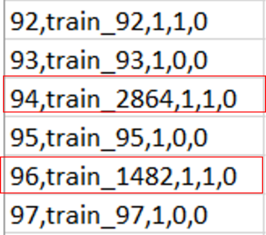

__2)__ There is in total 8543 rows in the csv file giving the label of the scanners. However, there are 8592 images in the training images file. Therefore, there are missing labels and we won't be able to use every image. The image for which we don't have the labels can probably be used in the test dataset. (There are around 50 images in the training set without labels) 

__3)__ In the test image dataset, the last image name is 'test_4037.png', but there is only 4019 elements in the folder. This means that there is some missing photos in the test dataset. For instance test_4.png is missing.

__4)__ The dataframe is going to be transformed into a dataframe with 5 columns:
- 'ID': integer variable, ID of the patient's brain scanner
- 'training_ID_path': image file path, giving the image file path to simplify image loading (the id in the image name should match the 'ID' on the same row)
- 'epi': binary variable, giving the presence or not of 'Epidural hematoma'
- 'int': binary variable, giving the presence or not of 'Subarachnoid hemorrhage'
- 'sub': binary variable, giving the presence or not of 'Intraparenchymal hemorrhage'
- 'labels': string, giving the label of the data
- 'labels_int': integer between 0 and 7, each integer correspond to one class. This step is necessary before feeding the labels to the model. A correspondance table will be given for clarity purpose.

## II. 1) Formatting the dataframe


In [147]:
# Read training set labels from filename.csv
df = pd.read_csv('behold_coding_challenge_train.csv')


# Dropping first column that is Unnamed since it doesn't give the real ID of the patient
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# Rename columns and duplicate an ID column from the real 'ID' column of the csv file. 
# This will ensure that only the images that have labels are kept

df = df.rename(columns={'ID': 'train_ID_path'})
df = df.rename(columns={'epidural': 'epi'}) 
df = df.rename(columns={'intraparenchymal': 'int'}) 
df = df.rename(columns={'subarachnoid': 'sub'}) 
ID = df['train_ID_path']         
df.insert(0, 'ID', ID) 


# Deleting string 'train_' in the 'ID' column, convert into integers and sort by ID
df['ID'] = df['ID'].str.replace('train_',' ') 
df['ID'] = df['ID'].astype(int)
df = df.sort_values(by=['ID'])


# Formatting the train_ID_path column into the image file path
df['train_ID_path'] = 'train_images/train_images/' + df['train_ID_path'].astype(str) + '.png'


# Create labels column
labels = pd.DataFrame(df[['epi','int','sub']])
labels = classes.applymap(str)
labels['labels'] = labels[['epi','int','sub']].apply(lambda x: ''.join(x), axis=1)
df.insert(5, 'labels', labels['labels']) 


# Encode the classes into integer label before feeding
d = {'label': [0,1,2,3,4,5,6,7], 'class': ['000','001','010','011','100','101','110','111']}
label_correspondance = pd.DataFrame(data=d)
print('Correspondance table:')
print(label_correspondance)

le = preprocessing.LabelEncoder()
le.fit(['000','001','010','011','100','101','110','111'])
list(le.classes_)
labels_int = le.transform(df['labels'])
df.insert(6, 'labels_int', labels_int) 


# Output 
df

Correspondance table:
   label class
0      0   000
1      1   001
2      2   010
3      3   011
4      4   100
5      5   101
6      6   110
7      7   111


,ID,train_ID_path,epi,int,sub,labels,labels_int
0,0,train_images/train_images/train_0.png,1,0,1,101,5
1,1,train_images/train_images/train_1.png,1,0,0,100,4
2,2,train_images/train_images/train_2.png,1,0,1,101,5
3,3,train_images/train_images/train_3.png,1,0,1,101,5
4,4,train_images/train_images/train_4.png,1,0,0,100,4
...,...,...,...,...,...,...,...
8537,8588,train_images/train_images/train_8588.png,0,0,0,000,0
8538,8589,train_images/train_images/train_8589.png,0,0,0,000,0
8539,8590,train_images/train_images/train_8590.png,0,0,0,000,0
8540,8591,train_images/train_images/train_8591.png,0,0,0,000,0


## II. 2) Data pipeline 1: Defining functions loading images and feeding images (model.fit used for 1st model)

__Function 'load_image'__ is a function taking a image_path as input, and giving the matrix of the image pixel values as output

In [148]:
def load_image(path):
    img = image.imread(path)
    return img

In [149]:
# Train-validation split

# Preparing the image matrix
x = df['train_ID_path']
x = list(np.array(x))
X = []

for i in range(len(x)):
    X += [list(load_image(x[i]))]
X = np.array(X)


# Preparing the label matrix
y = np.array(df['labels_int'])


# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)



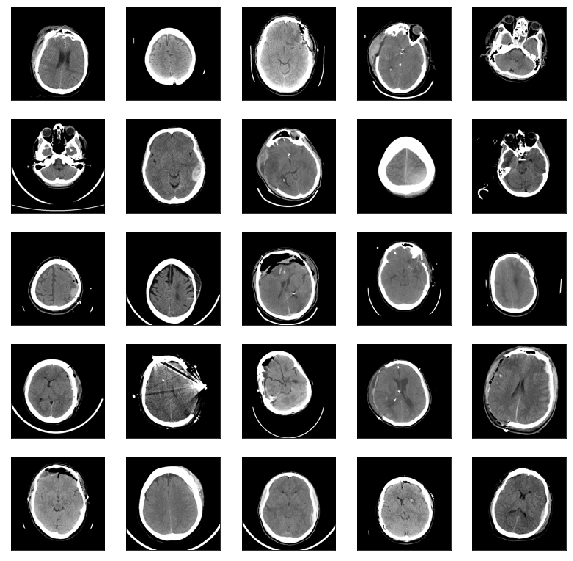

In [150]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i],cmap = 'gray')
plt.show()

## II.3) Data Pipeline 2: Feeding models with batches of images (model.fit_generator used for 2nd, 3rd model)

### Training images

In [151]:
# Read training set labels from filename.csv
df = pd.read_csv('behold_coding_challenge_train.csv')

# Rename column for convenience
df = df.rename(columns={'ID': 'filename'}) 
df = df.rename(columns={'epidural': 'epi'}) 
df = df.rename(columns={'intraparenchymal': 'int'}) 
df = df.rename(columns={'subarachnoid': 'sub'}) 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['filename'] = df['filename'].astype(str) + '.png'

# Output 
df

,filename,epi,int,sub
0,train_0.png,1,0,1
1,train_1.png,1,0,0
2,train_2.png,1,0,1
3,train_3.png,1,0,1
4,train_4.png,1,0,0
...,...,...,...,...
8537,train_8588.png,0,0,0
8538,train_8589.png,0,0,0
8539,train_8590.png,0,0,0
8540,train_8591.png,0,0,0


### Test images

In [152]:
test_image_path = "./test_images/test_images"
test_images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
test = pd.DataFrame(test_images,columns = ['filename'])

# Deleting string 'train_' in the 'filename' column, convert into integers and sort by id
test['filename'] = test['filename'].str.replace('test_','') 
test['filename'] = test['filename'].str.replace('.png','') 
test['filename'] = test['filename'].astype(int)
test = test.sort_values(by=['filename'])


# Formatting the train_ID_path column into the image file path
test['filename'] = 'test_' + test['filename'].astype(str) + '.png'

# Output 
test

,filename
0,test_0.png
1,test_1.png
1104,test_2.png
2215,test_3.png
3472,test_5.png
...,...
3364,test_4033.png
3365,test_4034.png
3366,test_4035.png
3367,test_4036.png


#### Note: The file names are order in an increasing order in the dataframe now

### Building training, validation and test generators

In [153]:
columns=["epi", "int", "sub"]
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

# Test-validation dataset split
test_datagen=ImageDataGenerator(rescale=1./255.)

print('Training data:')
train_generator=datagen.flow_from_dataframe(
        dataframe=df,
        directory="./train_images/train_images",
        x_col="filename",
        y_col=columns,
        subset="training",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="other",
        target_size=(128,128),
        color_mode = "grayscale")


print('Validation data:')
valid_generator=datagen.flow_from_dataframe(
        dataframe=df,
        directory="./train_images/train_images",
        x_col="filename",
        y_col=columns,
        subset="validation",
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode="other",
        target_size=(128,128),
        color_mode = "grayscale")


print('Test data:')
test_generator=test_datagen.flow_from_dataframe(
        dataframe=test,
        directory="./test_images/test_images",
        x_col='filename',
        batch_size=1,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(128,128),
        color_mode = 'grayscale')

Training data:
Found 6834 validated image filenames.
Validation data:
Found 1708 validated image filenames.
Test data:
Found 4019 validated image filenames.


***

# III. Building and training Neural Networks

## III.1) 1st Neural network:
#### For this first neural network, I decided to classify the images in 8 classes: '000','001','010','011','100','101','110','111'
#### This is probably not the most appropriate way knowing that the classes are not independent between them, but it is a first try before diving into more complex model.

In [244]:
model1 = keras.Sequential()
model1 = keras.Sequential([
        keras.layers.Flatten(input_shape=(128, 128)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(8, activation='softmax')
        ])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [245]:
history1 = model1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Train on 6833 samples, validate on 1709 samples
Epoch 1/10
6833/6833 [==============================] - 148s 22ms/sample - loss: 1.5940 - accuracy: 0.4227 - val_loss: 1.4009 - val_accuracy: 0.4394
Epoch 2/10
6833/6833 [==============================] - 5s 720us/sample - loss: 1.3295 - accuracy: 0.4508 - val_loss: 1.3762 - val_accuracy: 0.4424
Epoch 3/10
6833/6833 [==============================] - 4s 571us/sample - loss: 1.2857 - accuracy: 0.4639 - val_loss: 1.3397 - val_accuracy: 0.4470
Epoch 4/10
6833/6833 [==============================] - 4s 583us/sample - loss: 1.2452 - accuracy: 0.4748 - val_loss: 1.3320 - val_accuracy: 0.4558
Epoch 5/10
6833/6833 [==============================] - 4s 577us/sample - loss: 1.2194 - accuracy: 0.4803 - val_loss: 1.4107 - val_accuracy: 0.4219 - loss: 1.1832 - accuracy - ETA: 2s - loss: 1.1 - ETA: 1s - l - ETA: 0s -
Epoch 6/10
6833/6833 [==============================] - 4s 588us/sample - loss: 1.1901 - accuracy: 0.5058 - val_loss: 1.3616 - val_accura

### III.1) i) Results - 1st Neural network :

In [246]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               2097280   
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 1032      
Total params: 2,098,312
Trainable params: 2,098,312
Non-trainable params: 0
_________________________________________________________________


In [247]:
val_loss, val_acc = model1.evaluate(X_val,  y_val, verbose=2)

print('\nModel1 Validation accuracy:', val_acc)

1709/1 - 0s - loss: 1.5948 - accuracy: 0.4400

Model1 Validation accuracy: 0.4400234


### III.1) ii) Learning curve

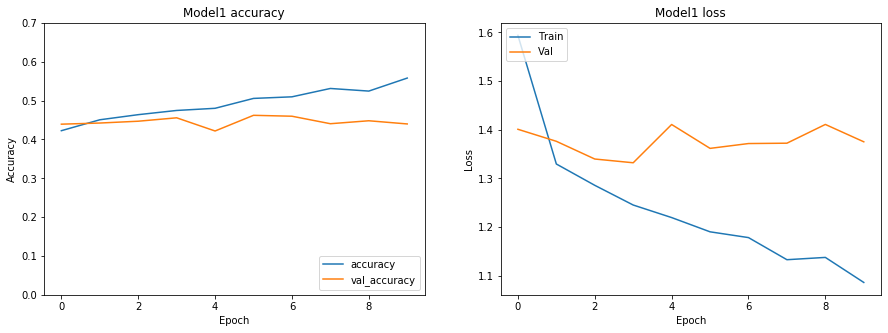

In [248]:
plt.figure(figsize = (15,5))
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.7])
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### III.1) iii) Confusion matrix and classification report

In [249]:
predictions1 = model1.predict(X_val)
y_pred1 = np.argmax(predictions1, axis = 1)

print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred1))

print('Classification Report')
target_names = ['000','001','010','011','100','101','110','111']
print(classification_report(y_val, y_pred1, target_names = target_names))


Confusion Matrix
[[464  99 117  18   1   0   0   0]
 [105  99  94  28   0   0   0   0]
 [103  72 165  24   0   0   0   0]
 [ 60  39 117  24   0   0   0   0]
 [ 18   5  16   9   0   0   0   0]
 [  2   1   4   1   1   0   0   0]
 [  3   2   5   5   0   0   0   0]
 [  0   1   6   1   0   0   0   0]]
Classification Report
              precision    recall  f1-score   support

         000       0.61      0.66      0.64       699
         001       0.31      0.30      0.31       326
         010       0.31      0.45      0.37       364
         011       0.22      0.10      0.14       240
         100       0.00      0.00      0.00        48
         101       0.00      0.00      0.00         9
         110       0.00      0.00      0.00        15
         111       0.00      0.00      0.00         8

    accuracy                           0.44      1709
   macro avg       0.18      0.19      0.18      1709
weighted avg       0.41      0.44      0.42      1709



D:\anaconda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### III.1) iv) Comparing distribution and prediction on validation data 

Support: distribution in the validation data
000    699
010    364
001    326
011    240
100     48
110     15
101      9
111      8
Name: class, dtype: int64
Prediction on validation data
000    755
010    524
001    318
011    110
100      2
Name: class, dtype: int64


Text(0.5, 1.0, 'Count Plot of classes from model1 predictions')

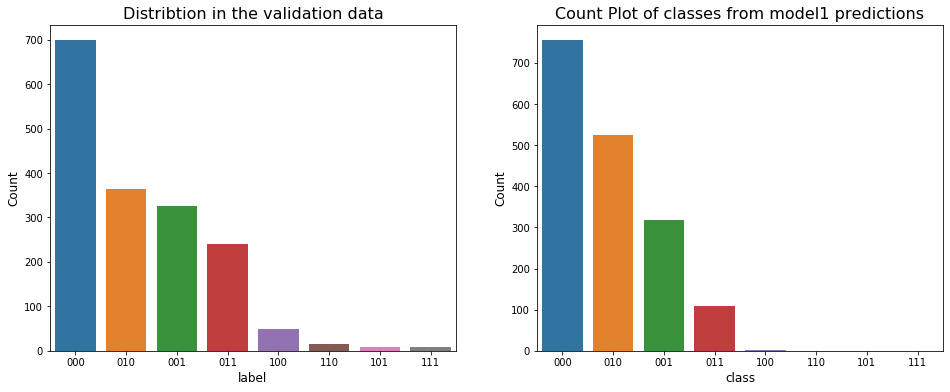

In [250]:
#=========================================================================================================================

print('Support: distribution in the validation data')
y_val1 = pd.DataFrame(y_val, columns = ['label'])
y_val1 = y_val1.merge(label_correspondance, on='label', how='left')

# Count the classes
print(y_val1['class'].value_counts())

# Plotting countplot of the distribution of the validation set of the different classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='class', data=y_val1, order = ['000','010','001','011','100','110','101','111'],ax=ax[0])
ax[0].set_xlabel('label', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Distribtion in the validation data', fontsize=16)



#=========================================================================================================================

print('Prediction on validation data')
y_pred1 = pd.DataFrame(y_pred1, columns = ['label'])
y_pred1 = y_pred1.merge(label_correspondance, on='label', how='left')

# Count the classes
print(y_pred1['class'].value_counts())

# Plotting countplot of the PREDICTION on validation set of the different classes
sns.countplot(x='class', data=y_pred1, order = ['000','010','001','011','100','110','101','111'],ax=ax[1])
ax[1].set_xlabel('class', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_title('Count Plot of classes from model1 predictions', fontsize=16)




### Note: 
- The accuracy is not really high with the training data and it's lower with the validation dataset. The overfitting issue need to be addressed, and the model will need to be improved.
- More complex models with convolutional layers will therefore need to be built in order to reach higher accuracy.
- We can notice in the figures above that the predictions of model 1 captured somehow the distribution of the validation data.

***

## III. 2) 2nd Neural Network
#### In this second Neural network, I chose to use a multi label classification with 3 output channels to recreate the output of the 3 types of brain damage.
#### 2 convolution layers and 2 dense layers are used in this structure.

In [161]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu', input_shape=(128, 128, 1)))
model2.add(keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')) 
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dense(3, activation='sigmoid'))

model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [162]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history2 = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)


Epoch 1/10
213/213 [==============================] - 121s 568ms/step - loss: 0.3845 - accuracy: 0.8007 - val_loss: 0.8554 - val_accuracy: 0.5136
Epoch 2/10
213/213 [==============================] - 116s 546ms/step - loss: 0.3229 - accuracy: 0.8385 - val_loss: 1.0051 - val_accuracy: 0.5057
Epoch 3/10
213/213 [==============================] - 118s 556ms/step - loss: 0.2600 - accuracy: 0.8728 - val_loss: 0.9331 - val_accuracy: 0.5776
Epoch 4/10
213/213 [==============================] - 118s 554ms/step - loss: 0.1753 - accuracy: 0.9229 - val_loss: 1.1995 - val_accuracy: 0.6105
Epoch 5/10
213/213 [==============================] - 119s 560ms/step - loss: 0.0948 - accuracy: 0.9644 - val_loss: 1.4339 - val_accuracy: 0.6164
Epoch 6/10
213/213 [==============================] - 121s 568ms/step - loss: 0.0432 - accuracy: 0.9858 - val_loss: 2.0361 - val_accuracy: 0.6075
Epoch 7/10
213/213 [==============================] - 139s 655ms/step - loss: 0.0198 - accuracy: 0.9949 - val_loss: 2.2320 -

### Note: 
- We can notice a noticeable better results in training accuracy compared to validation accuracy. However, the overfitting is still an issue that will be need to be addressed.

### III.2) i) Results - 2nd Neural network :

In [163]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        832       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               29491328  
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
Total params: 29,511,043
Trainable params: 29,511,043
Non-trainable params: 0
_________________________________________________________________


In [164]:
# Evaluation on validation data
val_loss, val_acc = model2.evaluate_generator(generator = valid_generator, verbose=2)

print('\nModel 2 Validation accuracy:', val_acc)

54/54 - 7s - loss: 2.8069 - accuracy: 0.6140

Model 2 Validation accuracy: 0.6139734


### III.2) ii) Learning curve


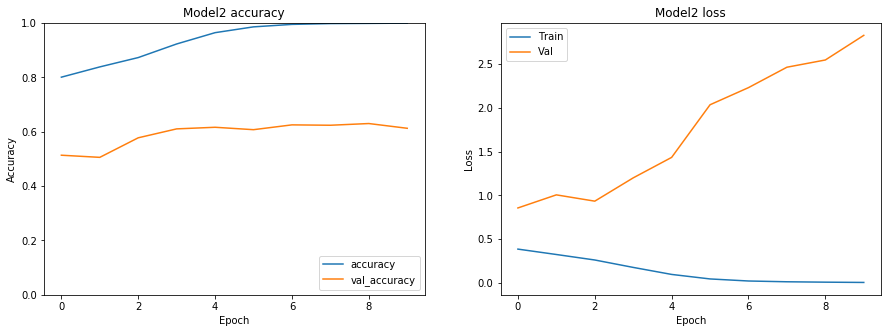

In [238]:
plt.figure(figsize=(15,5))
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model2 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### III.2) iii) Multi label classification evaluation metrics

#### Prediction on validation set with threshold = 0.5

In [166]:
# Prediction
pred2 = model2.predict_generator(valid_generator,
                                steps=STEP_SIZE_VALID+1,
                                verbose=1)


54/54 [==============================] - 8s 141ms/step


In [201]:
# Predictions labels
pred_bool2 = (pred2 >0.5)
predictions2 = pred_bool2.astype(int)
columns=["epi", "int", "sub"]


# True labels
y_Val2 = []
for i in range (len(valid_generator)): 
    y_Val2 += list(valid_generator[i][1])
y_Val2 = np.array(y_Val2)

#### Multi confusion matrix (threshold = 0.5)

In [202]:
# Multi confusion matrix
Multi_CM2 = multilabel_confusion_matrix(y_Val2, predictions2)

print("Confusion matrix for label 'epi'")
print(Multi_CM2[0])
print("Confusion matrix for label 'int'")
print(Multi_CM2[1])
print("Confusion matrix for label 'sub'")
print(Multi_CM2[2])

Confusion matrix for label 'epi'
[[1414    0]
 [ 286    8]]
Confusion matrix for label 'int'
[[165  51]
 [907 585]]
Confusion matrix for label 'sub'
[[708 569]
 [165 266]]


#### Classification report for each label (threshold = 0.5)

In [203]:
print(classification_report(y_Val2[:,0], predictions2[:,0], target_names=['no epi','epi']))
print(classification_report(y_Val2[:,1], predictions2[:,1], target_names=['no int','int']))
print(classification_report(y_Val2[:,2], predictions2[:,2], target_names=['no sub','sub']))

              precision    recall  f1-score   support

      no epi       0.83      1.00      0.91      1414
         epi       1.00      0.03      0.05       294

    accuracy                           0.83      1708
   macro avg       0.92      0.51      0.48      1708
weighted avg       0.86      0.83      0.76      1708

              precision    recall  f1-score   support

      no int       0.15      0.76      0.26       216
         int       0.92      0.39      0.55      1492

    accuracy                           0.44      1708
   macro avg       0.54      0.58      0.40      1708
weighted avg       0.82      0.44      0.51      1708

              precision    recall  f1-score   support

      no sub       0.81      0.55      0.66      1277
         sub       0.32      0.62      0.42       431

    accuracy                           0.57      1708
   macro avg       0.56      0.59      0.54      1708
weighted avg       0.69      0.57      0.60      1708



### Note: 
- We can notice that this second neural network gives slightly better results.The threshold determining if a scanner has a brain damage or not was set at 0.5. However, lowering it a little bit should increase the amount of false postives and reduce false negatives.Further analysis will be carried out to determining a optimal threshold.


***

# III. 3) 3rd Neural Network: 
### Multilabel classification with a more complex structure: Conv2D, Conv2D, Maxpooling2D, Conv2D, Conv2D, Maxpooling2D, Dense, Dense with sigmoid and binary cross_entropy

In [170]:
model3 = keras.Sequential()
model3.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=(128,128,1)))
model3.add(keras.layers.Conv2D(32, (3, 3),activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.25))

model3.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu',))
model3.add(keras.layers.Conv2D(64, (3, 3),activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.25))
model3.add(keras.layers.Flatten())

model3.add(keras.layers.Dense(512, activation = 'relu'))
model3.add(keras.layers.Dropout(0.5))

model3.add(keras.layers.Dense(3, activation='sigmoid'))
model3.compile(keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])


In [171]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history3 = model3.fit_generator(generator=train_generator,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_generator,
                                validation_steps=STEP_SIZE_VALID,
                                epochs=10)

Epoch 1/10
213/213 [==============================] - 529s 2s/step - loss: 0.3906 - accuracy: 0.7907 - val_loss: 0.7295 - val_accuracy: 0.5024
Epoch 2/10
213/213 [==============================] - 523s 2s/step - loss: 0.3649 - accuracy: 0.8042 - val_loss: 0.7716 - val_accuracy: 0.4894
Epoch 3/10
213/213 [==============================] - 522s 2s/step - loss: 0.3544 - accuracy: 0.8133 - val_loss: 0.7154 - val_accuracy: 0.5232
Epoch 4/10
213/213 [==============================] - 523s 2s/step - loss: 0.3488 - accuracy: 0.8169 - val_loss: 0.7712 - val_accuracy: 0.5256
Epoch 5/10
213/213 [==============================] - 523s 2s/step - loss: 0.3431 - accuracy: 0.8236 - val_loss: 0.9465 - val_accuracy: 0.5142
Epoch 6/10
213/213 [==============================] - 522s 2s/step - loss: 0.3377 - accuracy: 0.8251 - val_loss: 0.8091 - val_accuracy: 0.5320
Epoch 7/10
213/213 [==============================] - 523s 2s/step - loss: 0.3322 - accuracy: 0.8328 - val_loss: 0.8991 - val_accuracy: 0.5301

### III.3) i) Results - 3rd Neural network :

In [172]:
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)       

In [173]:
# Evaluation on validation data
val_loss3, val_acc3 = model3.evaluate_generator(generator = valid_generator, verbose=2)

print('\nModel 3 Validation accuracy:', val_acc3)



54/54 - 30s - loss: 0.9066 - accuracy: 0.5541

Model 3 Validation accuracy: 0.55405927


### III.3) ii) Learning curve


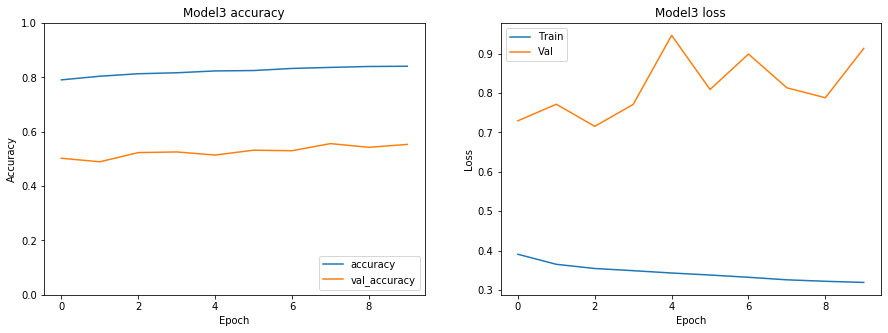

In [239]:
plt.figure(figsize=(15,5))
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model3 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### III.3) iii) Multi label confusion matrix and classification reports

####  Prediction on validation set with threshold = 0.5

In [175]:
# Prediction
pred3 = model3.predict_generator(valid_generator,
                                steps=STEP_SIZE_VALID+1,
                                verbose=1)


54/54 [==============================] - 28s 526ms/step


In [204]:
# Predictions labels
pred_bool3 = (pred3 >0.5)
predictions3 = pred_bool3.astype(int)
columns=["epi", "int", "sub"]


# True labels
y_Val3 = []
for i in range (len(valid_generator)): 
    y_Val3 += list(valid_generator[i][1])
y_Val3 = np.array(y_Val3)

#### Multi confusion matrix (threshold = 0.5)

In [205]:
# Multi confusion matrix
Multi_CM3 = multilabel_confusion_matrix(y_Val3, predictions3)

print("Confusion matrix for label 'epi'")
print(Multi_CM3[0])
print("Confusion matrix for label 'int'")
print(Multi_CM3[1])
print("Confusion matrix for label 'sub'")
print(Multi_CM3[2])


Confusion matrix for label 'epi'
[[1414    0]
 [ 294    0]]
Confusion matrix for label 'int'
[[172  44]
 [996 496]]
Confusion matrix for label 'sub'
[[432 845]
 [106 325]]


#### Classification report for each label (threshold = 0.5)

In [206]:
print(classification_report(y_Val3[:,0], predictions3[:,0], target_names=['no epi','epi']))
print(classification_report(y_Val3[:,1], predictions3[:,1], target_names=['no int','int']))
print(classification_report(y_Val3[:,2], predictions3[:,2], target_names=['no sub','sub']))

              precision    recall  f1-score   support

      no epi       0.83      1.00      0.91      1414
         epi       0.00      0.00      0.00       294

    accuracy                           0.83      1708
   macro avg       0.41      0.50      0.45      1708
weighted avg       0.69      0.83      0.75      1708

              precision    recall  f1-score   support

      no int       0.15      0.80      0.25       216
         int       0.92      0.33      0.49      1492

    accuracy                           0.39      1708
   macro avg       0.53      0.56      0.37      1708
weighted avg       0.82      0.39      0.46      1708

              precision    recall  f1-score   support

      no sub       0.80      0.34      0.48      1277
         sub       0.28      0.75      0.41       431

    accuracy                           0.44      1708
   macro avg       0.54      0.55      0.44      1708
weighted avg       0.67      0.44      0.46      1708



#### Plot precision, sensitivity, specitficity, f-1 score for threshold in [0.0, 1.0]

In [241]:
def metrics(threshold):
    m = np.ones((3,4))
    p_bool = (pred3 > threshold)
    p = p_bool.astype(int)
    M_CM = multilabel_confusion_matrix(y_Val3, p)
    
    #Epi
    precision_epi = M_CM[0][1][1]/(M_CM[0][1][1] + M_CM[0][0][1])
    sensitivity_epi = M_CM[0][1][1]/(M_CM[0][1][1] + M_CM[0][1][0])
    specificity_epi = M_CM[0][0][0]/(M_CM[0][0][1] + M_CM[0][0][0])
    f_1_epi = 2*precision_epi*sensitivity_epi/(precision_epi+sensitivity_epi)
    m[0] = np.array([precision_epi,sensitivity_epi,specificity_epi,f_1_epi])
    
    #Int
    precision_int = M_CM[1][1][1]/(M_CM[1][1][1] + M_CM[1][0][1])
    sensitivity_int = M_CM[1][1][1]/(M_CM[1][1][1] + M_CM[1][1][0])
    specificity_int = M_CM[1][0][0]/(M_CM[1][0][1] + M_CM[1][0][0])
    f_1_int = 2*precision_int*sensitivity_int/(precision_int+sensitivity_int)
    m[1] = np.array([precision_int,sensitivity_int,specificity_int,f_1_int])
    
    #Sub
    precision_sub = M_CM[2][1][1]/(M_CM[2][1][1] + M_CM[2][0][1])
    sensitivity_sub = M_CM[2][1][1]/(M_CM[2][1][1] + M_CM[2][1][0])
    specificity_sub = M_CM[2][0][0]/(M_CM[2][0][1] + M_CM[2][0][0])
    f_1_sub = 2*precision_sub*sensitivity_sub/(precision_sub+sensitivity_sub)
    m[2] = np.array([precision_sub,sensitivity_sub,specificity_sub,f_1_sub])
    
    return m

D:\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
D:\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app
D:\anaconda\envs\test\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars


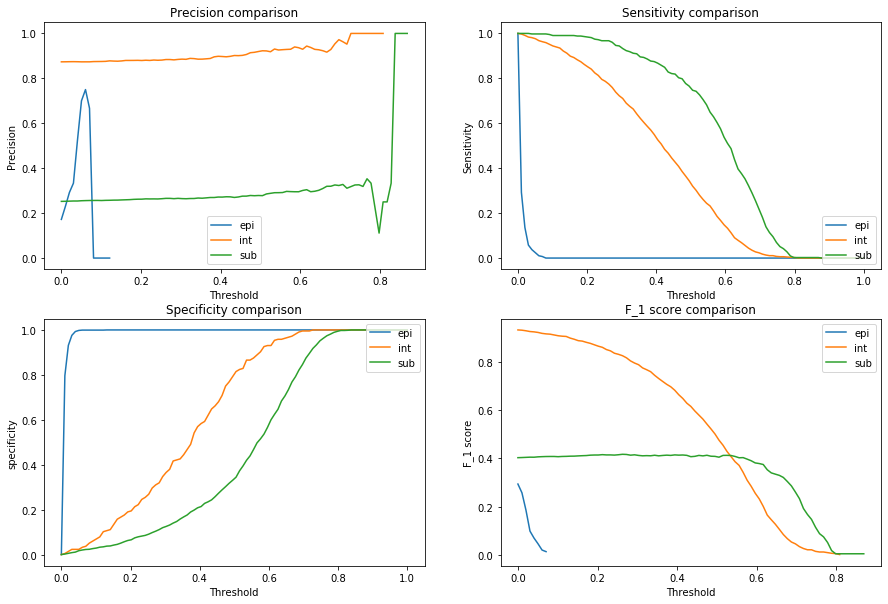

In [242]:
x = np.linspace(0,1,100)
pre_epi = np.array([metrics(i)[0,0] for i in x])
pre_int = np.array([metrics(i)[1,0] for i in x])
pre_sub = np.array([metrics(i)[2,0] for i in x])

sen_epi = np.array([metrics(i)[0,1] for i in x])
sen_int = np.array([metrics(i)[1,1] for i in x])
sen_sub = np.array([metrics(i)[2,1] for i in x])

spe_epi = np.array([metrics(i)[0,2] for i in x])
spe_int = np.array([metrics(i)[1,2] for i in x])
spe_sub = np.array([metrics(i)[2,2] for i in x])

f1_epi = np.array([metrics(i)[0,3] for i in x])
f1_int = np.array([metrics(i)[1,3] for i in x])
f1_sub = np.array([metrics(i)[2,3] for i in x])


plt.figure(figsize = (15, 10))
# Plot precision
plt.subplot(2, 2, 1)
plt.plot(x,pre_epi)
plt.plot(x,pre_int)
plt.plot(x,pre_sub)
plt.title('Precision comparison')
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.legend(['epi', 'int','sub'])

# # Plot sensitivity
plt.subplot(2, 2, 2)
plt.plot(x,sen_epi)
plt.plot(x,sen_int)
plt.plot(x,sen_sub)
plt.title('Sensitivity comparison')
plt.ylabel('Sensitivity')
plt.xlabel('Threshold')
plt.legend(['epi', 'int','sub'], loc='lower right')

# Plot specificity
plt.subplot(2, 2, 3)
plt.plot(x,spe_epi)
plt.plot(x,spe_int)
plt.plot(x,spe_sub)
plt.title('Specificity comparison')
plt.ylabel('specificity')
plt.xlabel('Threshold')
plt.legend(['epi', 'int','sub'], loc='upper right')

# Plot f_1
plt.subplot(2, 2, 4)
plt.plot(x,f1_epi)
plt.plot(x,f1_int)
plt.plot(x,f1_sub)
plt.title('F_1 score comparison')
plt.ylabel('F_1 score')
plt.xlabel('Threshold')
plt.legend(['epi', 'int','sub'])
plt.show()

#### Precision-recall curve

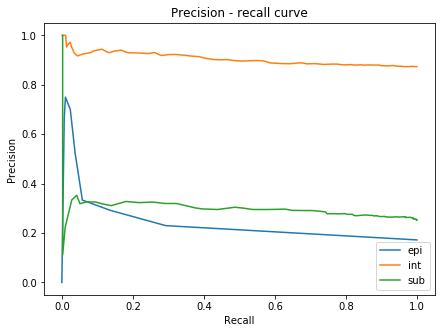

In [243]:
# Plot precision-recall curve
plt.figure(figsize = (7, 5))
plt.plot(sen_epi,pre_epi)
plt.plot(sen_int,pre_int)
plt.plot(sen_sub,pre_sub)
plt.title('Precision - recall curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(['epi', 'int','sub'])
plt.show()

### Note: 
- We can notice that this 3rd model has a good performance in detecting the true negative in class 'int', compared to the two other classes. The precision for 'epi' is really low. These two observations can be partially explained by the fact that there were way more (010) than (100) in the original dataset.
- It can be notice a tradeoff between sensitivity and specifity. A high sensitivity means that actual positives are not overlooked(so few false negatives), and high specifity means that actual negative are correctly classified(and false positive not overlooked). A highly sensisitive and specific test would definitely be preferred.
- In our case, we would prefer having a higher number of false positives than false negatives. Therefore a threshold at 0.4 would be chosen for the prediction on the test data.


***

# IV. Predictions on test data

####  I have chosen to use ultimately the 3rd model to create my predictions on the test data.

In [179]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred_test = model3.predict_generator(test_generator,
                                steps=STEP_SIZE_TEST,
                                verbose=1)


4019/4019 [==============================] - 145s 36ms/step


In [251]:

prediction_test = (pred_test >0.4)
prediction_test = prediction_test.astype(int)
columns=["epi", "int", "sub"]

#columns should be the same order of y_col
results_test = pd.DataFrame(prediction_test, columns=columns)
results_test["Filenames"] = test_generator.filenames
ordered_cols = ["Filenames"] + columns
results = results_test[ordered_cols]  #To get the same column order
results.to_csv("test_results.csv",index = False)

# Conclusion

In this assignment, I have started by exploring the image dataset and the label dataset seperatedly. Some data preprocessiong were then conducted before training the neural network models.<br>
Moreover, since the 1st model is a simpler model compared to the 2nd and the 3rd one, I used 'Model_fit' for 1st NN model and 'Model.fit_generator' for the 2 others. This required a different way to feed the data to the neural network, in the latter case, generators were created to feed images in batches of 32.<br>
Then, I built the structures of 3 different NN. By evaluating on the validation data, I have chosen the 2nd model, since it gives best results regarding validation accuracy, precision, recall and f-1 scores.
Finally, the predicted results of the test images were saved in the 'test_results.csv'.

The perfomance of these neural networks still have improvement potentials. The overfitting issue need to be addressed. For instance, data augmentation can be a way to adress this problem. We can notice that some classes have more instances in the original dataset than others. By rotating, blurring, flipping the images, we can capture more images to train the network, especially for those classes with few instances.

At the end, for the prediction on the real data set. I decided to use a threshold at 0.4 considering the medical field in which these images are analyzed. These neural networks are used in context of hospitals, where the output is reviewed by professional doctors.
This test will probably display a high rate of false positives, but it still can be considered valuable because they greatly increase the likelihood of detecting disorders at a far earlier stage. The population screening test wshould be indeed cheap and produce few false-negatives. The false-positives can subsequently be sorted out by more sophisticated testing.
